In [1]:
pip install pyspark dask

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, isnull, sum

In [3]:
spark=SparkSession.builder.appName("Store Data Analysis").getOrCreate()

In [4]:
df=spark.read.csv('store.csv',header=True,inferSchema=True)

In [5]:
df.show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+----------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|   PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+----------------+
|    1|        c|         a|               1270|                        9|                    2008|     0|           NULL|           NULL|            NULL|
|    2|        a|         a|                570|                       11|                    2007|     1|             13|           2010| Jan,Apr,Jul,Oct|
|    3|        a|         a|              14130|                       12|                    2006|     1|             14|           2011| Jan,Apr,Jul,Oct|
|    4|        c|         c|                620|                

In [6]:
df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: integer (nullable = true)
 |-- CompetitionOpenSinceYear: integer (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



In [7]:
print(f"Total rows:{df.count()}")

Total rows: 1115


In [19]:
df=df.fillna({
    "CompetitionDistance": 0,
    "CompetitionOpenSinceMonth": 1,
    "CompetitionOpenSinceYear": 2000,
    "Promo2SinceWeek": 0,
    "Promo2SinceYear": 2000,
    "PromoInterval": "No Promo"
})

In [20]:
df.describe().show()

+-------+-----------------+---------+----------+-------------------+-------------------------+------------------------+------------------+------------------+------------------+---------------+
|summary|            Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|            Promo2|   Promo2SinceWeek|   Promo2SinceYear|  PromoInterval|
+-------+-----------------+---------+----------+-------------------+-------------------------+------------------------+------------------+------------------+------------------+---------------+
|  count|             1115|     1115|      1115|               1115|                     1115|                    1115|              1115|              1115|              1115|           1115|
|   mean|            558.0|     NULL|      NULL|  5390.358744394619|        5.248430493273543|      2005.9165919282511|0.5121076233183857| 12.08340807174888|2006.0242152466367|           NULL|
| stddev|322.0170802923348|     NUL

In [21]:
null_count=df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])

In [22]:
null_count.show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
|    0|        0|         0|                  0|                        0|                       0|     0|              0|              0|            0|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+



In [23]:
df.select("StoreType").distinct().show()

+---------+
|StoreType|
+---------+
|        d|
|        c|
|        b|
|        a|
+---------+



In [24]:
df.groupBy("StoreType").count().show()

+---------+-----+
|StoreType|count|
+---------+-----+
|        d|  348|
|        c|  148|
|        b|   17|
|        a|  602|
+---------+-----+



In [28]:
df.groupBy("StoreType").agg(avg("CompetitionDistance").alias("AvgDistance")).show()

+---------+------------------+
|StoreType|       AvgDistance|
+---------+------------------+
|        d| 6873.333333333333|
|        c|3522.5675675675675|
|        b|1060.5882352941176|
|        a| 5114.551495016612|
+---------+------------------+



In [29]:
df.groupBy("Promo2").count().show()

+------+-----+
|Promo2|count|
+------+-----+
|     1|  571|
|     0|  544|
+------+-----+



In [38]:
# Total sales by StoreType
df.groupBy("StoreType").agg(sum("Sales").alias("TotalSales")).show()

+---------+------------------+
|StoreType|        TotalSales|
+---------+------------------+
|        d|1030703.3358680384|
|        c| 432756.7425810383|
|        b|  51152.9682510166|
|        a|1843550.8146958286|
+---------+------------------+



In [39]:
df.show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+----------------+------------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|   PromoInterval|             Sales|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+----------------+------------------+
|    1|        c|         a|               1270|                        9|                    2008|     0|              0|           2000|        No Promo|1188.4714625441188|
|    2|        a|         a|                570|                       11|                    2007|     1|             13|           2010| Jan,Apr,Jul,Oct|1673.9394589541953|
|    3|        a|         a|              14130|                       12|                    2006|     1|             14|   

In [46]:
from pyspark.sql import functions as F

In [47]:
df=df.withColumn("Sales",(df["CompetitionDistance"]/1000)*100 + 
                   (df["Promo2"]*200) + 
                   (df["Assortment"].cast("double")*300))

In [48]:
df.groupBy("StoreType").agg(F.sum("Sales").alias("TotalSales")).show()

+---------+----------+
|StoreType|TotalSales|
+---------+----------+
|        d|  279592.0|
|        c|   67134.0|
|        b|    2803.0|
|        a|  365696.0|
+---------+----------+



In [50]:
df.select("StoreType", "Sales").show()

+---------+------------------+
|StoreType|             Sales|
+---------+------------------+
|        c|             127.0|
|        a|             257.0|
|        a|            1613.0|
|        c|              62.0|
|        a|            2991.0|
|        a|              31.0|
|        a|            2400.0|
|        a|             752.0|
|        a|202.99999999999997|
|        a|             316.0|
|        a|             296.0|
|        a|             307.0|
|        d|             231.0|
|        a|             330.0|
|        d|             611.0|
|        a|             327.0|
|        a|             205.0|
|        d|            1584.0|
|        a|             524.0|
|        d|             434.0|
+---------+------------------+
only showing top 20 rows



In [71]:
import matplotlib.pyplot as plt 

In [72]:
store_types = ['d', 'c', 'b', 'a']
total_sales = [279592.0, 67134.0, 2803.0, 365696.0]

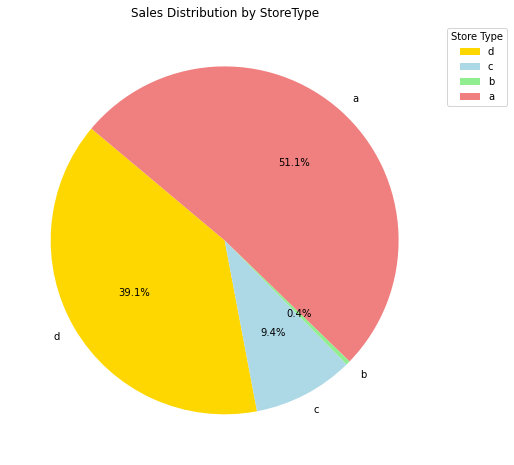

In [75]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_sales, labels=store_types,autopct='%1.1f%%',startangle=140,colors=['gold', 'lightblue','lightgreen','lightcoral'])

# Title and additional customization
plt.title('Sales Distribution by StoreType')
plt.legend(store_types, title="Store Type",loc="upper left",bbox_to_anchor=(1,1))
plt.show()

In [76]:
df.show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+----------------+------------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|   PromoInterval|             Sales|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+----------------+------------------+
|    1|        c|       0.0|               1270|                        9|                    2008|     0|              0|           2000|        No Promo|             127.0|
|    2|        a|       0.0|                570|                       11|                    2007|     1|             13|           2010| Jan,Apr,Jul,Oct|             257.0|
|    3|        a|       0.0|              14130|                       12|                    2006|     1|             14|   